# Data Import

In [63]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm as cm
import matplotlib.patches as mpatches # plot t-SNE
import missingno as msno

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, auc
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE # t-SNE

from sklearn import tree
from sklearn.tree import export_graphviz
import pydot

from mlxtend.feature_selection import SequentialFeatureSelector as sfs # feature selection

import seaborn as sns 

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

import lightgbm as lgb

from scipy import stats
from scipy.stats import norm
import time # t-SNE model

In [65]:
df_raw = pd.read_csv('data/creditcard-training.csv')

# Data Exploration

In [66]:
# Get shape
df_raw.shape

(227844, 32)

In [67]:
# Print head
df_raw.head()

,Seconds since reference time,Amount,"Fraud? (1: Fraud, 0: No Fraud)",Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
0,0,149.62,0,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,...,0.462388,0.239599,0.098698,-6.399372,-0.311169,-0.991390,-0.617801,-0.551600,0.090794,0.363787
1,0,2.69,0,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,...,-0.082361,-0.078803,0.085102,13.786441,-0.143772,0.489095,1.065235,1.612727,-0.166974,-0.255425
2,1,378.66,0,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,...,1.800499,0.791461,0.247676,-10.515321,-0.165946,0.717293,0.066084,0.624501,0.207643,-1.514654
3,1,123.50,0,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,...,1.247203,0.237609,0.377436,2.961038,-0.287924,0.507757,0.178228,-0.226487,-0.054952,-1.387024
4,2,69.99,0,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,...,0.095921,0.592941,-0.270533,2.751346,-1.119670,1.345852,0.538196,-0.822843,0.753074,0.817739


In [68]:
# Get basic statistics about the dataset
df_raw.describe()

,Seconds since reference time,Amount,"Fraud? (1: Fraud, 0: No Fraud)",Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
count,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227817.000000,227785.000000,227844.000000,...,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000
mean,79042.504749,90.825317,0.001830,0.049116,-0.005509,0.015160,-0.022870,-0.007268,0.009942,-0.005657,...,0.030540,-0.026843,0.003986,0.027511,0.032867,0.016712,-0.045001,0.076274,-0.001708,0.002219
std,39505.785991,250.504249,0.042742,0.933915,0.885633,0.874173,0.842786,0.820008,0.779124,0.761744,...,1.321420,1.228243,1.209610,8.652541,0.965725,1.019592,1.055865,1.033516,1.093933,1.123424
min,0.000000,0.000000,0.000000,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-28.009635,-34.830382,...,-26.160506,-43.557242,-73.216718,-14.999725,-19.214325,-5.791881,-18.683715,-4.797473,-24.588262,-13.434066
25%,47694.000000,6.000000,0.000000,-0.543185,-0.478638,-0.457550,-0.514930,-0.478224,-0.202767,-0.225600,...,-0.731719,-0.568948,-0.195151,-7.466957,-0.386010,-0.651170,-0.453237,-0.682527,-0.522697,-0.662053
50%,73261.000000,23.400000,0.000000,0.120841,0.059919,-0.045765,-0.025810,-0.006006,-0.051034,-0.034863,...,-0.237643,0.009785,0.033492,0.044266,0.067860,-0.001631,0.118528,0.030157,-0.093071,-0.067951
75%,120396.000000,79.990000,0.000000,0.724566,0.528866,0.410328,0.476318,0.468337,0.145096,0.168401,...,0.432330,0.532569,0.332266,7.521777,0.509023,0.686509,0.611637,0.835856,0.456881,0.612866
max,145245.000000,19656.530000,1.000000,5.825654,8.289890,9.253526,5.041069,5.591971,39.420904,27.202839,...,22.529298,36.877368,20.007208,14.999989,10.526766,4.569009,7.848392,12.018913,23.745136,15.594995


In [69]:
# Rename the Fraud column
df_raw = df_raw.rename( {'Fraud? (1: Fraud, 0:  No Fraud)' : 'Fraud'}, axis=1)
df_raw.head()

,Seconds since reference time,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
0,0,149.62,0,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,...,0.462388,0.239599,0.098698,-6.399372,-0.311169,-0.991390,-0.617801,-0.551600,0.090794,0.363787
1,0,2.69,0,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,...,-0.082361,-0.078803,0.085102,13.786441,-0.143772,0.489095,1.065235,1.612727,-0.166974,-0.255425
2,1,378.66,0,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,...,1.800499,0.791461,0.247676,-10.515321,-0.165946,0.717293,0.066084,0.624501,0.207643,-1.514654
3,1,123.50,0,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,...,1.247203,0.237609,0.377436,2.961038,-0.287924,0.507757,0.178228,-0.226487,-0.054952,-1.387024
4,2,69.99,0,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,...,0.095921,0.592941,-0.270533,2.751346,-1.119670,1.345852,0.538196,-0.822843,0.753074,0.817739


In [70]:
# Get NAs 
df_raw[df_raw.isnull().any(axis=1)].head()

,Seconds since reference time,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
10,10,7.80,0,0.230930,0.031967,0.253415,0.854344,NaN,-0.387226,-0.009302,...,-0.629152,-1.423236,0.048456,-13.640428,-0.095045,-0.513947,-0.671440,1.199644,1.626659,-1.720408
16,12,12.99,0,0.354574,-0.246635,-0.009212,-0.595912,-0.575682,NaN,-0.024612,...,0.288069,-0.586057,0.189380,8.579468,-0.468647,0.708380,0.936708,-0.450311,-0.267975,0.782333
25,22,26.43,0,-0.211668,-0.333321,0.010751,-0.488473,0.505751,NaN,-0.403639,...,-0.959537,0.543985,-0.104627,-10.985595,-0.279797,-0.655233,-0.180523,-0.856566,0.149451,0.475664
28,23,33.00,0,0.076804,-1.405919,0.775592,-0.942889,NaN,0.097308,0.077237,...,-0.200331,0.740228,-0.029247,-5.123601,-0.086324,0.635954,0.786796,-0.012142,-0.346188,-0.593392
42,33,14.80,0,0.235545,-1.347811,0.504648,-0.798405,0.759710,NaN,-0.087329,...,0.119168,0.850893,-0.176267,5.560997,-0.365439,0.481917,0.398299,-0.387003,0.148455,-0.243501


# Exploratory Data Analysis for Outlier Detection

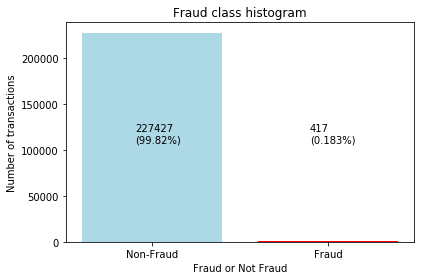

In [71]:
# Checking the Target Classes

plt.bar(['Non-Fraud','Fraud'], df_raw['Fraud'].value_counts(), color=['lightblue','red'])
plt.title("Fraud class histogram")
plt.xlabel('Fraud or Not Fraud')
plt.ylabel('Number of transactions')
plt.annotate('{}\n({:.4}%)'.format(df_raw['Fraud'].value_counts()[0], 
                                         df_raw['Fraud'].value_counts()[0]/df_raw['Fraud'].count()*100),
             (0.20, 0.45), xycoords='axes fraction', color="black")
plt.annotate('{}\n({:.4}%)'.format(df_raw['Fraud'].value_counts()[1], 
                                         df_raw['Fraud'].value_counts()[1]/df_raw['Fraud'].count()*100),
             (0.70, 0.45), xycoords='axes fraction', color="black")
plt.tight_layout()
plt.show()

<div class="alert alert-danger">
    The historgram shows that there is a need for resampling 
</div>

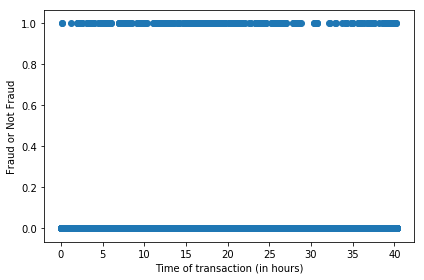

In [72]:
plt.scatter(df_raw['Seconds since reference time']/(60*60), df_raw['Fraud'])
plt.xlabel('Time of transaction (in hours)')
plt.ylabel('Fraud or Not Fraud')

plt.tight_layout()

plt.show()

<div class="alert alert-danger">
The "Seconds since reference time" variable isn't a good predictor for frauds. As seen above, the pattern for both non-fradulent and fraudulent transactions seems to be random regardless of the hour of the day.
</div>

### Looking at the entire dataset

Number of outliers below the lower bound:  0  (0.0%)
Number of outliers above the upper bound:  25355  (11.13%)


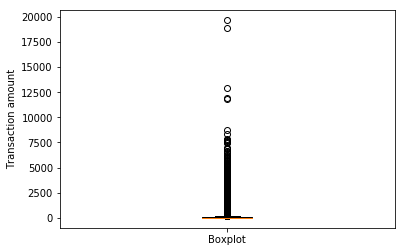

In [73]:
plt.boxplot(df_raw['Amount'], labels = ['Boxplot'])
plt.ylabel('Transaction amount')
plt.plot()

amount = df_raw[['Amount']].sort_values(by='Amount')
q1, q3 = np.percentile(amount,[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)

print('Number of outliers below the lower bound: ', amount[amount['Amount'] < lower_bound].count()[0],
     ' ({:.4}%)'.format(amount[amount['Amount'] < lower_bound].count()[0] / amount['Amount'].count() * 100))
print('Number of outliers above the upper bound: ', amount[amount['Amount'] > upper_bound].count()[0],
      ' ({:.4}%)'.format(amount[amount['Amount'] > upper_bound].count()[0] / amount['Amount'].count() * 100))

<div class="alert alert-danger">
The interquartile range method found <b>25355</b> outliers, which represents <b>11.13%</b> of the observations. Removing them from the dataset would be a bad idea due to the loss of a large amount of information for the machine learning models.
</div>

In [74]:
df_raw[df_raw['Fraud']==1].where(df_raw['Amount']>upper_bound).count()['Amount']

75

<div class="alert alert-danger">
In addition to that, only 75 out of 25355 outliers are classified as frauds.
</div>

### Now we look at the concentration non-fraudulent and fraudulent transactions.

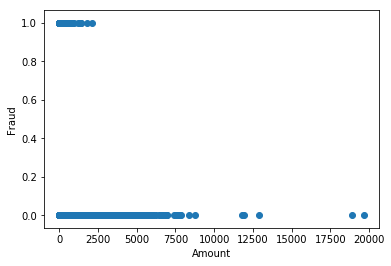

In [75]:
plt.scatter(df_raw['Amount'], df_raw['Fraud'])
plt.xlabel('Amount')
plt.ylabel('Fraud')
plt.show()

<div class="alert alert-success">
    Looks like the Fraudulent transactions are more concentrated towards the lower amounts
</div>

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


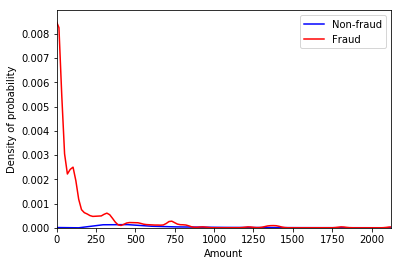

In [76]:
target_0 = df_raw.loc[df_raw['Fraud'] == 0]
target_1 = df_raw.loc[df_raw['Fraud'] == 1]
ax1=sns.distplot(target_0[['Amount']], hist=False, color='b', label='Non-fraud')
ax2=sns.distplot(target_1[['Amount']], hist=False, color='r', label='Fraud')
ax1.set_xlim(0, max(df_raw[df_raw['Fraud']==1]['Amount']))
ax2.set_xlim(0, max(df_raw[df_raw['Fraud']==1]['Amount']))
plt.legend()
plt.xlabel('Amount')
plt.ylabel('Density of probability')
plt.show()

<div class="alert alert-success">
    Thus, we confirm that the fraudulent transactions are highly concentrated at smaller values when compared to non-fraudulent transactions.
</div>

### Looking at detailed Features

In [77]:
tab_info = df_raw.describe()
#Add info on range
tab_info=tab_info.append(pd.DataFrame(df_raw.max()-df_raw.min()).T.rename(index={0:'range (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_raw.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_raw.isnull().sum()/df_raw.shape[0]*100).T.rename(index={0:'null values (%)'}))
tab_info

,Seconds since reference time,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
count,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227817.000000,227785.000000,227844.000000,...,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000,227844.000000
mean,79042.504749,90.825317,0.001830,0.049116,-0.005509,0.015160,-0.022870,-0.007268,0.009942,-0.005657,...,0.030540,-0.026843,0.003986,0.027511,0.032867,0.016712,-0.045001,0.076274,-0.001708,0.002219
std,39505.785991,250.504249,0.042742,0.933915,0.885633,0.874173,0.842786,0.820008,0.779124,0.761744,...,1.321420,1.228243,1.209610,8.652541,0.965725,1.019592,1.055865,1.033516,1.093933,1.123424
min,0.000000,0.000000,0.000000,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-28.009635,-34.830382,...,-26.160506,-43.557242,-73.216718,-14.999725,-19.214325,-5.791881,-18.683715,-4.797473,-24.588262,-13.434066
25%,47694.000000,6.000000,0.000000,-0.543185,-0.478638,-0.457550,-0.514930,-0.478224,-0.202767,-0.225600,...,-0.731719,-0.568948,-0.195151,-7.466957,-0.386010,-0.651170,-0.453237,-0.682527,-0.522697,-0.662053
50%,73261.000000,23.400000,0.000000,0.120841,0.059919,-0.045765,-0.025810,-0.006006,-0.051034,-0.034863,...,-0.237643,0.009785,0.033492,0.044266,0.067860,-0.001631,0.118528,0.030157,-0.093071,-0.067951
75%,120396.000000,79.990000,0.000000,0.724566,0.528866,0.410328,0.476318,0.468337,0.145096,0.168401,...,0.432330,0.532569,0.332266,7.521777,0.509023,0.686509,0.611637,0.835856,0.456881,0.612866
max,145245.000000,19656.530000,1.000000,5.825654,8.289890,9.253526,5.041069,5.591971,39.420904,27.202839,...,22.529298,36.877368,20.007208,14.999989,10.526766,4.569009,7.848392,12.018913,23.745136,15.594995
range (nb),145245.000000,19656.530000,1.000000,10.324599,22.419744,34.416326,14.539815,12.805499,67.430540,62.033221,...,48.689804,80.434610,93.223927,29.999714,29.741092,10.360890,26.532107,16.816387,48.333399,29.029061
null values (nb),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000,59.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<div class="alert alert-success">
We have identified that Features 16, 19, 21, and 22 have an unsually large range as compared to the rest. <br/>
Just to confirm we will be plotting distribution plots
</div>

## Data Transformation

### Drop Time column

In [78]:
df = df_raw.copy()
df.drop('Seconds since reference time', axis=1, inplace=True)

### Handle Missing Values

We will be looking for missing values

In [79]:
df[df.isnull().any(axis=1)].head()

,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
10,7.80,0,0.230930,0.031967,0.253415,0.854344,NaN,-0.387226,-0.009302,0.313894,...,-0.629152,-1.423236,0.048456,-13.640428,-0.095045,-0.513947,-0.671440,1.199644,1.626659,-1.720408
16,12.99,0,0.354574,-0.246635,-0.009212,-0.595912,-0.575682,NaN,-0.024612,0.196002,...,0.288069,-0.586057,0.189380,8.579468,-0.468647,0.708380,0.936708,-0.450311,-0.267975,0.782333
25,26.43,0,-0.211668,-0.333321,0.010751,-0.488473,0.505751,NaN,-0.403639,-0.227404,...,-0.959537,0.543985,-0.104627,-10.985595,-0.279797,-0.655233,-0.180523,-0.856566,0.149451,0.475664
28,33.00,0,0.076804,-1.405919,0.775592,-0.942889,NaN,0.097308,0.077237,0.457331,...,-0.200331,0.740228,-0.029247,-5.123601,-0.086324,0.635954,0.786796,-0.012142,-0.346188,-0.593392
42,14.80,0,0.235545,-1.347811,0.504648,-0.798405,0.759710,NaN,-0.087329,0.258315,...,0.119168,0.850893,-0.176267,5.560997,-0.365439,0.481917,0.398299,-0.387003,0.148455,-0.243501


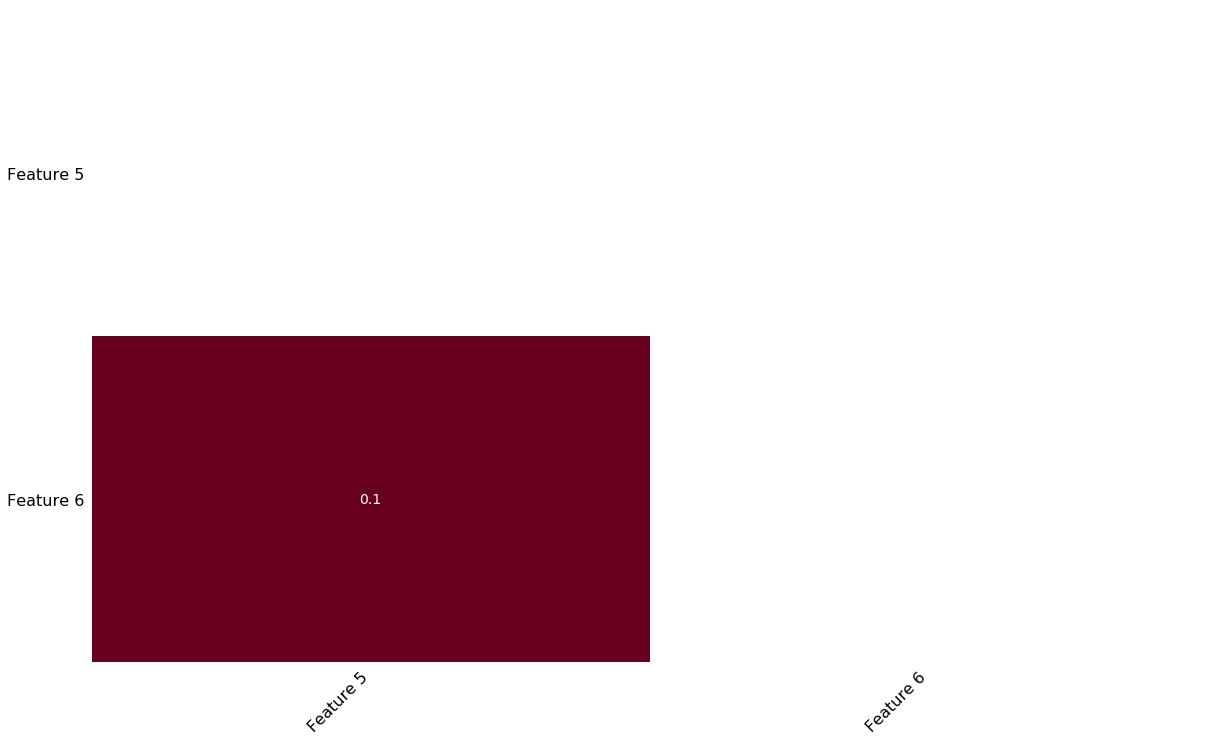

In [80]:
#Visualise the Correleation Matrix about the locations of missing values in columns 
msno.heatmap(df)


<div class="alert alert-success">
This heatmap signifies that the missing values in features 5 and 6 are correlated to each other and they are  `Missing Not at Random` (MNAR) <br/>
Therefore, dropping the rows will make the model biased and we will be using `Imputation` instead
</div>

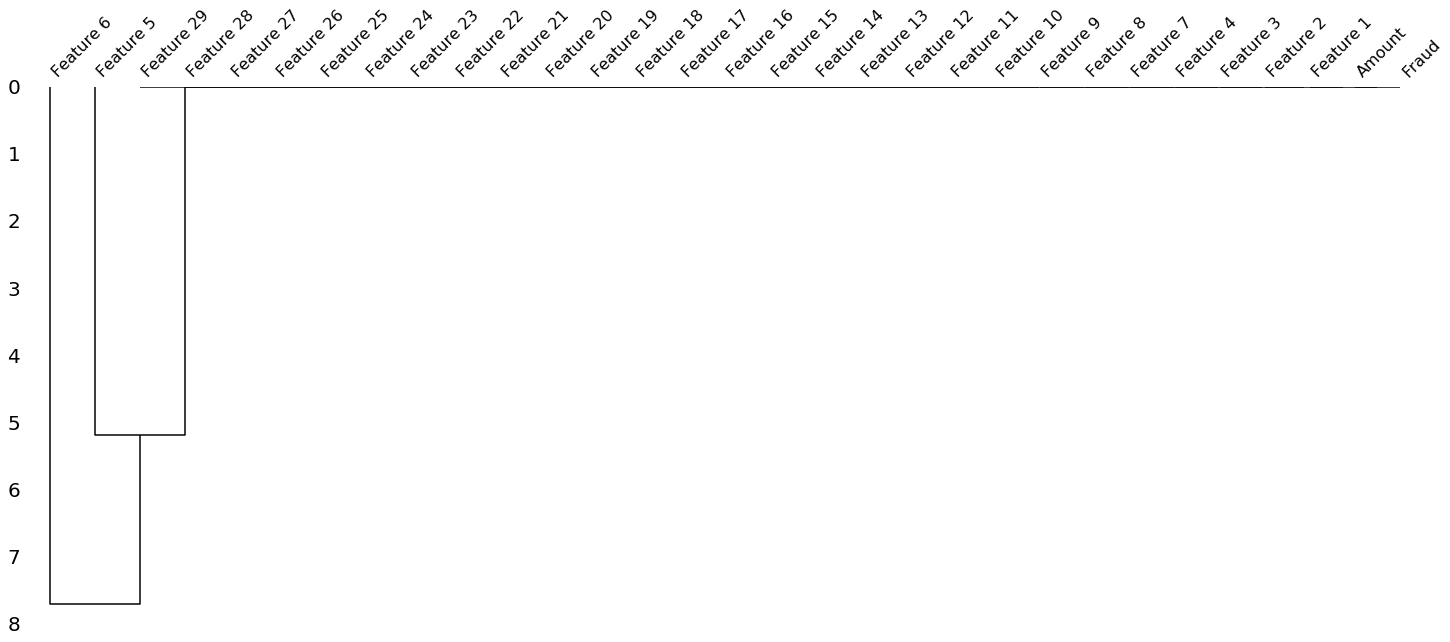

In [81]:
msno.dendrogram(df)

<div class="alert alert-success">
Again, signifies features are correlated
</div>

In [82]:
#Use sklearn Impute to impute missing values
features = df.values
imp = SimpleImputer(missing_values = np.nan, strategy='median')

#Only feature 5 and feature 6 have NaN
features[:,[6,7]] = imp.fit_transform(features[:,[6,7]])

df1 = pd.DataFrame(features)
df1.columns = df.columns
df = df1

#Check whether we've left out any null variables

df[df.isnull().any(axis=1)]

,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


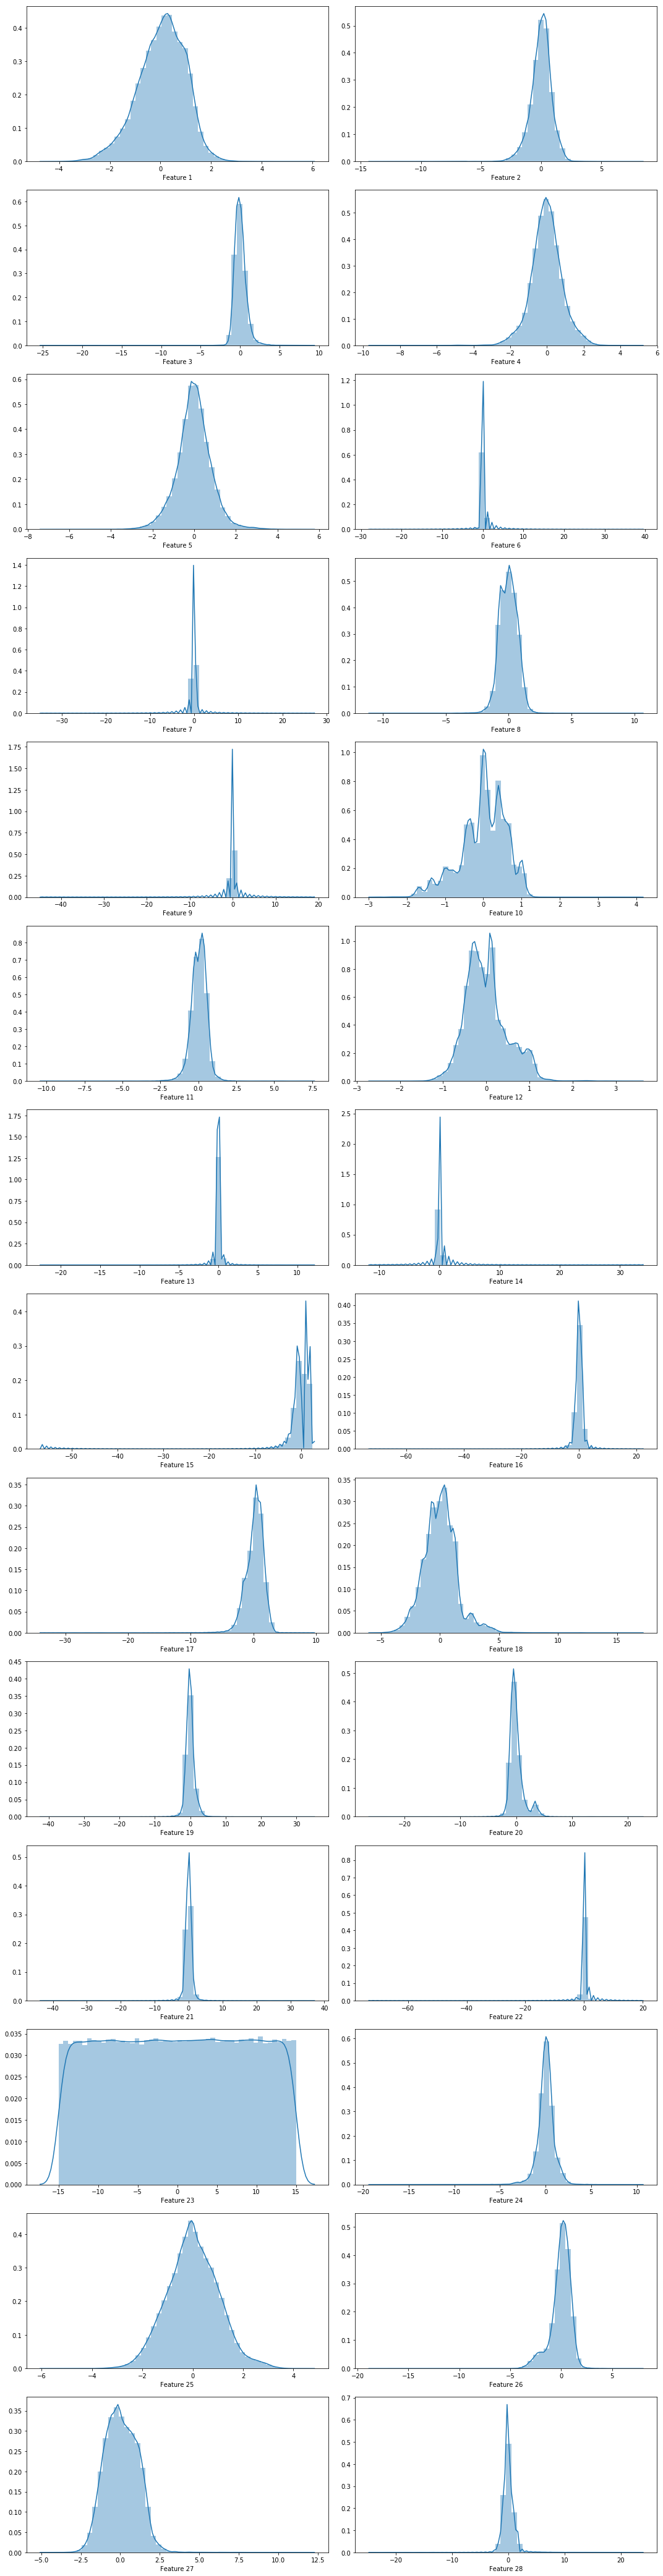

In [83]:
#Print distribution of all columns
V = df[[col for col in df_raw.columns if 'Feature' in col]]

f, ax = plt.subplots(ncols = 2, nrows = 14, figsize=(15,2*len(V.columns)))


for i, c in zip(ax.flatten(), V.columns):
    sns.distplot(V[c], ax = i)

f.tight_layout()

<div class="alert alert-success">
Most of the features have skewed distribution, we investigate further into the ones which we suspect have anomalies <br/>
Based on the table and the distribution plot above we will investigate into Features 16, 19, 21, and 22
</div>

### Anomaly Detection

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


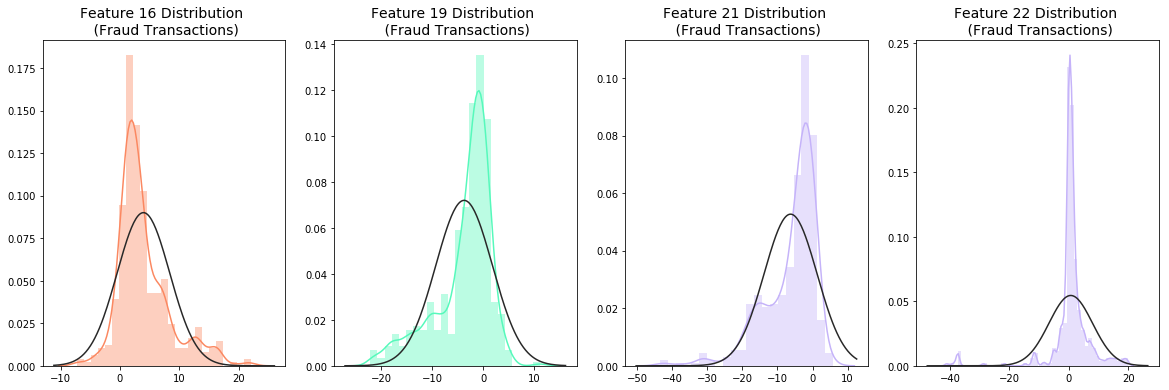

In [131]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 6))

v7_fraud_dist = df_raw['Feature 16'].loc[df_raw['Fraud'] == 1].values
sns.distplot(v7_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Feature 16 Distribution \n (Fraud Transactions)', fontsize=14)

v16_fraud_dist = df_raw['Feature 19'].loc[df_raw['Fraud'] == 1].values
sns.distplot(v16_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Feature 19 Distribution \n (Fraud Transactions)', fontsize=14)

v21_fraud_dist = df_raw['Feature 21'].loc[df_raw['Fraud'] == 1].values
sns.distplot(v21_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Feature 21 Distribution \n (Fraud Transactions)', fontsize=14)

v22_fraud_dist = df_raw['Feature 22'].loc[df_raw['Fraud'] == 1].values
sns.distplot(v22_fraud_dist,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('Feature 22 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

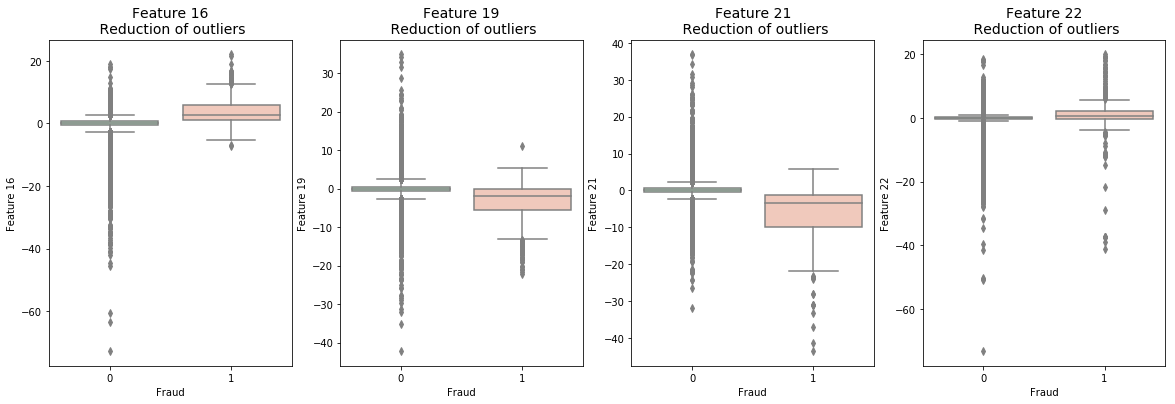

In [85]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']

# Feature 16
sns.boxplot(x="Fraud", y="Feature 16", data=df_raw,ax=ax1, palette=colors)
ax1.set_title("Feature 16\n Reduction of outliers", fontsize=14)

# Feature 19
sns.boxplot(x="Fraud", y="Feature 19", data=df_raw, ax=ax2, palette=colors)
ax2.set_title("Feature 19\n Reduction of outliers", fontsize=14)

# Feature 21
sns.boxplot(x="Fraud", y="Feature 21", data=df_raw, ax=ax3, palette=colors)
ax3.set_title("Feature 21\n Reduction of outliers", fontsize=14)

# Feature 22
sns.boxplot(x="Fraud", y="Feature 22", data=df_raw, ax=ax4, palette=colors)
ax4.set_title("Feature 22\n Reduction of outliers", fontsize=14)


plt.show()

### We will check for outliers in both fraud and non fraud category

In [86]:
#Get difference in means between Fraud and not-fraud
df_raw.groupby('Fraud').mean()

,Seconds since reference time,Amount,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
Fraud,,,,,,,,,,,,,,,,,,,,,
0,79064.020002,90.761453,0.049387,0.002841,0.028799,-0.018164,-0.008677,0.009279,-0.007071,-0.022976,...,0.033086,-0.015406,0.002776,0.026436,0.045807,0.016831,-0.032826,0.068994,0.009538,0.007167
1,67308.333333,125.656379,-0.098209,-4.559229,-7.423533,-2.589217,0.766809,0.374396,0.765659,0.013088,...,-1.357987,-6.264641,0.663762,0.613894,-7.024019,-0.048627,-6.685076,4.046820,-6.135121,-2.696376


<div class="alert alert-danger">
We can observe that certain variables (like `Feature 3`, and `Feature 26`) are drastically different for fraud and non-fraud categories
</div>

In [132]:
#Get number of fraud and not fraud values
fraud_rows = df['Fraud'].value_counts()
total_rows = df.shape[0]
percentage_fraud = fraud_rows[1]/total_rows

print("Fraud rows: ", fraud_rows[1])
print("Total rows: ", total_rows)
print("Percentage rows: ", percentage_fraud)

Fraud rows:  417
Total rows:  227844
Percentage rows:  0.0018301996102596514


### Check for Duplicates

In [88]:
df[df.duplicated()==True]

,Amount,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29


<div class="alert alert-success">
There are no duplicates. So we can move on.
</div>

### Scaling

Since the value of amount have a very different scale from the rest, we should consider normalising the columns "Amount" and "Seconds since reference time"

In [ ]:
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Amount'],axis=1)

### T-SNE

We will be applying t-SNE (t-Distributed Stochastic Neighbor Embedding) to ensure that the data can now be split into fraudulent and non-fraudulent transactions

In [90]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 417 rows.
fraud_df = df.loc[df['Fraud'] == 1]
non_fraud_df = df.loc[df['Fraud'] == 0][:417]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Fraud,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,normAmount
36596,0.0,1.114877,-0.448470,-0.078769,0.059322,0.324667,-0.076765,0.138632,0.536785,-0.186578,...,0.756299,-0.238079,-8.787122,0.343574,-0.757539,-0.430031,-0.310085,0.230965,-0.299020,-0.320935
181828,0.0,0.956799,-0.081782,-0.689017,-0.093283,0.317094,0.091788,-0.187587,-0.220944,-0.200850,...,0.760581,-0.390521,-8.766112,-0.690671,1.332226,0.558053,-0.445551,-0.160015,0.360767,-0.315226
6719,1.0,-1.334988,-2.689284,-3.204383,0.086522,-1.314495,0.632710,0.536892,-0.546126,-0.605240,...,-2.436653,0.489328,13.248199,-11.543498,-0.342444,-10.285283,7.620089,-6.810813,-3.371639,-0.358579
47511,0.0,1.703675,-2.721715,1.194318,-1.488585,-2.222745,-0.502187,-0.598836,-1.283717,0.309933,...,-0.248646,0.243610,5.409666,0.421944,0.421017,0.449573,0.547614,0.524128,-1.275580,-0.075389
191074,1.0,0.234980,-0.907666,-0.391051,-0.034719,1.084286,-1.586144,0.010663,1.786681,-0.151178,...,3.791907,-1.351045,7.676024,0.712541,-0.272079,-0.540535,-1.542305,-0.084500,0.095186,2.514832


In [91]:
# New_df is from the random undersample data (fewer instances)
# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

X = new_df.drop('Fraud', axis=1)
y = new_df['Fraud']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

T-SNE took 6.9 s


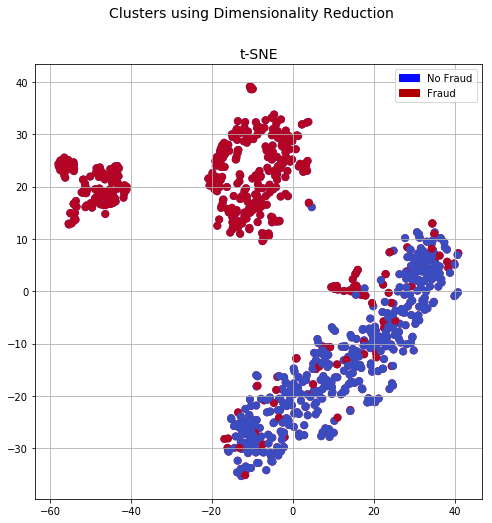

In [96]:
f, ax1 = plt.subplots(1, 1, figsize=(8,8))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

plt.show()

<div class="alert alert-success">
t-SNE tells us if our prediction model will correctly able to cluster our training set datapoints correctly <br/>
From the plot above, we can see that the data can be classified into fraud and non-fraud and thus, we will be moving forward with it
</div>

## Feature Selection

### Correlation Matrix

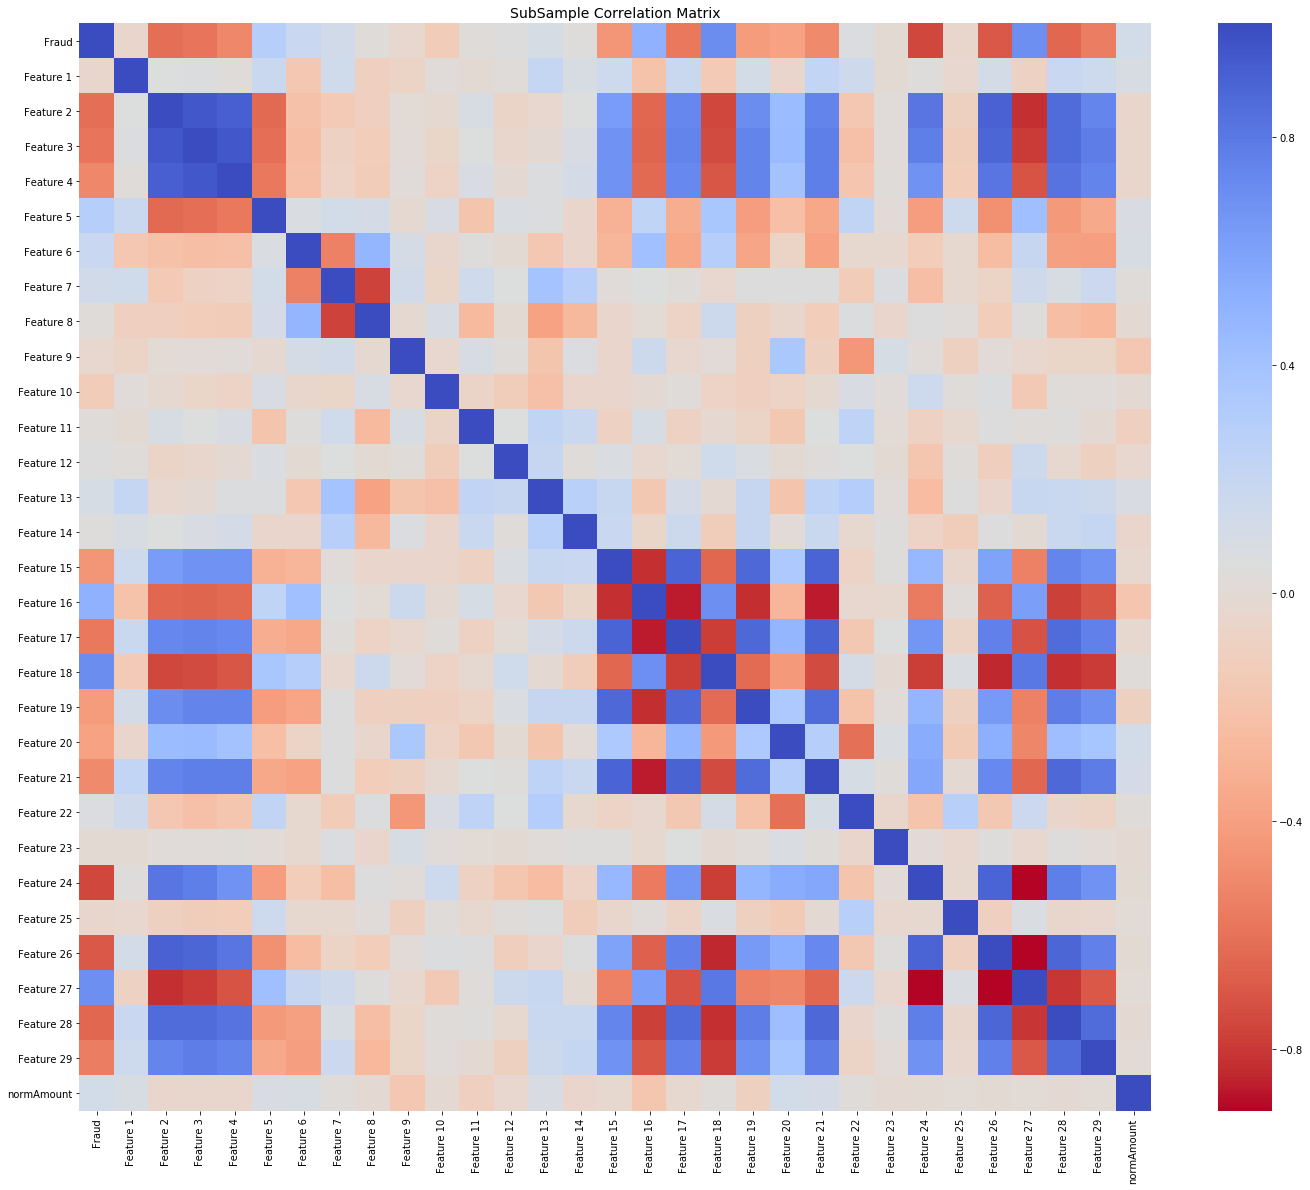

In [25]:
# Shuffle dataframe rows
df_sample = normal_distributed_df.sample(frac=1, random_state=42)

f, ax1 = plt.subplots(1, 1, figsize=(24,20))

sub_sample_corr = df_sample.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title('SubSample Correlation Matrix', fontsize=14)
plt.show()

<div class="alert alert-success">
We can see below that all features have very low correlation with the 'Fraud' feature. This was already expected since the data was processed using PCA.

<b>Negative Correlations</b>: Features (7 and 8), (15 and 16), (16 and 17), (16 and 21), (24 and 27), (26 and 27) are negatively correlated. <br/>
<b>Positive Correlations</b>:Features (2,3, and 4), (2 and 26), (15 and 21) are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.
</div>

So now we will be removing features 7, 16, 27, 2, 21

In [ ]:
normal_distributed_df.drop(['Feature 2', 'Feature 3', 'Feature 7', 'Feature 16', 'Feature 18', 'Feature 21', 'Feature 27'], axis=1, inplace=True)
df.drop(['Feature 2', 'Feature 3', 'Feature 7', 'Feature 16', 'Feature 18', 'Feature 21', 'Feature 27'], axis=1, inplace=True)

## Random Forest - Forward Selection

We will be using Random Forest to get the important features

In [135]:
#These datasets will be used in the forward selection procedure
y_small = normal_distributed_df['Fraud']
X_small = normal_distributed_df.drop('Fraud', axis=1)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, train_size=0.8, random_state=0)

#These will be used for model evaluation
y = df['Fraud']
X = df.drop('Fraud', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [36]:
# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=24, n_jobs=-1)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=19,  #19 has been chosen after multiple trial-errors
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy')

# Perform SFFS
sfs1 = sfs1.fit(X_train_small, y_train_small)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    4.8s finished

[2019-03-29 04:59:08] Features: 1/19 -- score: 0.8831077694235588[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s finished

[2019-03-29 04:59:13] Features: 2/19 -- score: 0.934057365636313[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    4.0s finished

[2019-03-29 04:59:17] Features: 3/19 -- score: 0.9369980506822613[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [136]:
# Get the features that were selected as predictors
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

# feat_cols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 18, 19, 20, 21, 22]
#Therefore, the selected features are: feat_cols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 18, 19, 20, 21, 22]

In [41]:
# Build full model with selected features
clf = RandomForestClassifier(n_estimators=24, random_state=42)
clf.fit(X_train.iloc[:, feat_cols], y_train)

y_train_pred = clf.predict(X_train.iloc[:, feat_cols])
print('Training accuracy on selected features: %.10f' % f1_score(y_train, y_train_pred))

y_test_pred = clf.predict(X_test.iloc[:, feat_cols])
print('Testing accuracy on selected features: %.10f' % f1_score(y_test, y_test_pred))

Training accuracy on selected features: 0.9940476190
Testing accuracy on selected features: 0.8689655172


In [137]:
#Extract only those features from the predictors
X_train = X_train.iloc[:, feat_cols]
X_test = X_test.iloc[:, feat_cols]

# Data Resampling

In [138]:
#We'll keep the ratio for Fraud 2:3 such that it is balanced enough to train the model without creating too many synthetic points
smote = SMOTE(sampling_strategy=0.67, kind='regular') #Oversampling
method2 = SMOTETomek(sampling_strategy=0.67, random_state=49, smote = smote) #Undersampling

In [139]:
# Apply resampling (using SMOTETomek) to the training data only
X_resampled, y_resampled = method2.fit_sample(X_train, y_train)

In [103]:
print("Before resampling")
print(pd.value_counts(pd.Series(y)))

# Print the value_counts
print("After resampling")
print(pd.value_counts(pd.Series(y_resampled)))

Before resampling
0.0    227427
1.0       417
Name: Fraud, dtype: int64
After resampling
0.0    181943
1.0    121901
dtype: int64


# Models to detect Fraud

In [140]:
def getWeightedFScore(fp,fn, wfp=1.4, wfn=0.6):#Weight to be changed by company
    return (wfp+wfn)*fp*fn/(wfp*fp+wfn*fn)

In [141]:
def printEvaluationMetrics(auc_score, y_test, predicted):
    precision = precision_score(y_test, predicted)
    recall = recall_score(y_test, predicted)
    f1_score_val = f1_score(y_test, predicted)
    weighted_fscore = getWeightedFScore(precision, recall)
    
    print("AUC Score: ", round(auc_score,3))
    print("Precision: ", round(precision,3))
    print("Recall: ", round(recall,3))
    print("F1 SCORE: ", round(f1_score_val, 3))
    print("Weighted Accuracy: ", round(weighted_fscore, 3))

## Logistic Regression

In [186]:
# Continue fitting the model and obtain predictions
model_lr = LogisticRegression()

#non-resampled gives better results
model_lr.fit(X_train, y_train)

# Get your performance metrics
predicted = model_lr.predict(X_test)

# Predict probabilities
probs = model_lr.predict_proba(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


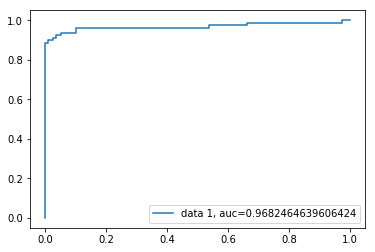

In [158]:
#Printing ROC Curve that shows tradeoff between Sensitivity and Specificity 
probs = model_lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  probs)
auc_score_lr = roc_auc_score(y_test, probs)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_score_lr))
plt.legend(loc=4)
plt.show()


In [147]:
#Evaluating
printEvaluationMetrics(auc_score, y_test, predicted)

AUC Score:  0.96
Precision:  0.88
Recall:  0.557
F1 SCORE:  0.682
Weighted Accuracy:  0.626


## Decision Tree 

In [150]:
model_dt = DecisionTreeClassifier(random_state=5)

# Fit the model to our resampled dataset
model_dt.fit(X_resampled, y_resampled)

# Obtain predictions from the test data 
predicted = model_dt.predict(X_test)

# Predict probabilities
probs = model_dt.predict_proba(X_test)

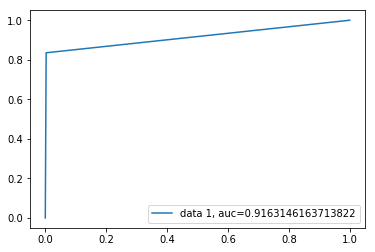

In [159]:
#Printing ROC Curve that shows tradeoff between Sensitivity and Specificity 
probs = model_dt.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  probs)
auc_score_dt = roc_auc_score(y_test, probs)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_score_dt))
plt.legend(loc=4)
plt.show()


In [152]:
#Evaluating
printEvaluationMetrics(auc_score_dt, y_test, predicted)

AUC Score:  0.916
Precision:  0.34
Recall:  0.835
F1 SCORE:  0.484
Weighted Accuracy:  0.581


### Parameter tuning for Decision Tree

In [153]:
# Number of features to consider at every split
max_features = [2,4,6,8,10]
# Maximum number of levels in tree
max_depth = [5, 10, 20, 40, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
dt_grid = {'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf}
print(dt_grid)

{'max_features': [2, 4, 6, 8, 10], 'max_depth': [5, 10, 20, 40, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [75]:
# Use the dt grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = dt_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
dt_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   28.6s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'max_features': [2, 4, 6, 8, 10], 'max_depth': [5, 10, 20, 40, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [154]:
# #Get Best Params
dt_random.best_params_

# {'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 8,
#  'max_depth': 20}

{'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 8,
 'max_depth': 20}

In [162]:
# To evaluate whether parameter tuning gave a better result, we will be evaluating the results

model_dt_best = dt_random.best_estimator_
model_dt_best.fit(X_train, y_train)
predicted = model_dt_best.predict(X_test)
probs = model_dt_best.predict_proba(X_test)

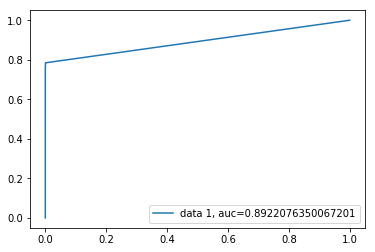

In [163]:
#Printing ROC Curve that shows tradeoff between Sensitivity and Specificity 
probs = model_dt_best.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  probs)
auc_score_dt_best = roc_auc_score(y_test, probs)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_score_dt_best))
plt.legend(loc=4)
plt.show()

In [164]:
#Evaluating
printEvaluationMetrics(auc_score_dt_best, y_test, predicted)

AUC Score:  0.892
Precision:  0.938
Recall:  0.759
F1 SCORE:  0.839
Weighted Accuracy:  0.805


## Random Forest

### Parameter tuning for Random Forest

### Using RandomSearchCV

In [127]:
# Number of trees in random forest
n_estimators = [10, 20, 40, 80, 100, 200, 400]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [5, 10, 20, 40, 60, 80, 100, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 40, 80, 100, 200, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 20, 40, 60, 80, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [129]:
# Create error in case I try to run the cell below by mistake
# Use the random grid to search for best hyperparameters
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# First create the base model to tune
rf = RandomForestClassifier()
# Search across 60 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/sk

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [10, 20, 40, 80, 100, 200, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 20, 40, 60, 80, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [130]:
# #Get Best Params
rf_random.best_params_

# {'n_estimators': 80,
#  'min_samples_split': 5,
#  'min_samples_leaf': 1,
#  'max_features': 'sqrt',
#  'max_depth': 40,
#  'bootstrap': False}

{'n_estimators': 80,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

In [132]:
best_random = rf_random.best_estimator_
predicted = best_random.predict(X_test)
print("Optimized Evaluation Metrics: " )
printEvaluationMetrics(0, y_test, predicted)
#F1 score: 0.8679245283018868

Optimized Evaluation Metrics: 
AUC Score:  0.54
Precision:  0.932
Recall:  0.861
F1 SCORE:  0.895
Weighted Accuracy:  0.881


In [142]:
# Define the model as the random forest
model_rf_re = RandomForestClassifier(n_estimators=80,random_state=5, min_samples_split=5, min_samples_leaf=1, 
                                     max_features='sqrt', max_depth=40, bootstrap=False)

# Fit the model to our resampled dataset
model_rf_re.fit(X_resampled, y_resampled)

# Obtain predictions from the test data 
predicted = model_rf_re.predict(X_test)

# Predict probabilities
probs = model_rf_re.predict_proba(X_test)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=40, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

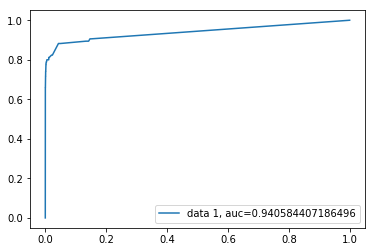

In [107]:
#Printing ROC Curve that shows tradeoff between Sensitivity and Specificity 
probs = model_rf_re.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  probs)
auc_score_rf_re = roc_auc_score(y_test, probs)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_score_rf_re))
plt.legend(loc=4)
plt.show()

In [108]:
printEvaluationMetrics(auc_score_rf_re, y_test, predicted)

AUC Score:  0.941
Precision:  0.885
Recall:  0.635
F1 SCORE:  0.74
Weighted Accuracy:  0.694


### Random forest with AdaBoost

In [194]:
X_test.shape

(45568, 19)

In [143]:
#Use model initialised above
model_ada_rf = AdaBoostClassifier(base_estimator=model_rf_re, random_state=42)

#Use resampled data
model_ada_rf.fit(X_resampled, y_resampled)

#Predict for testing dataset
predicted = model_ada_rf.predict(X_test)

probs = model_ada_rf.predict_proba(X_test)

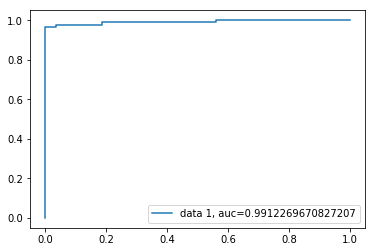

In [195]:
#Printing ROC Curve that shows tradeoff between Sensitivity and Specificity 
probs = model_ada_rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  probs)
auc_score_ada_rf = roc_auc_score(y_test, probs)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_score_ada_rf))
plt.legend(loc=4)
plt.show()

In [196]:
printEvaluationMetrics(auc_score_ada_rf, y_test, predicted)

AUC Score:  0.991
Precision:  1.0
Recall:  0.966
F1 SCORE:  0.983
Weighted Accuracy:  0.976


<div class="alert alert-success">
    <h2> Model Selected ! </h2>
    <br/>
    Therefore, we can see that Random Forest with AdaBoost Classifier has the best AUC score and the best F-score <br/>
    We will be using this as our final predictors
</div>

In [144]:
precision, recall, thresholds = precision_recall_curve(y_test, probs[:, 1])
pr_auc = auc(recall, precision)

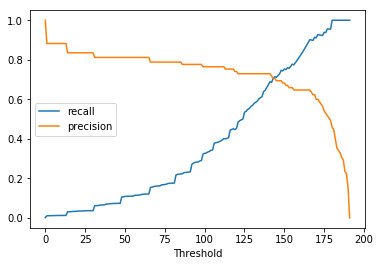

In [145]:
#Precision Recall Curve
plt.plot(precision)
plt.plot(recall)
plt.xlabel('Threshold')
plt.legend(['recall', 'precision'])
plt.show()

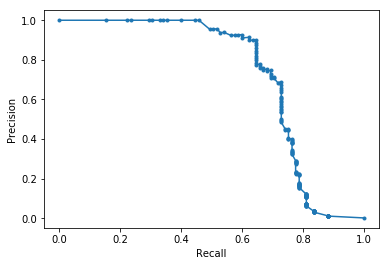

In [171]:
#Precision Recall Curve 2
plt.plot(recall, precision, marker='.')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [150]:
def getFeatureImportance(importances, features):
    featImp = []
    for imp,feat in zip(importances, features):
        featImp.append((imp, feat))
    return featImp

In [152]:
featImps = getFeatureImportance(model_ada_rf.feature_importances_, X_train.columns)

Text(0, 0.5, 'Importance')

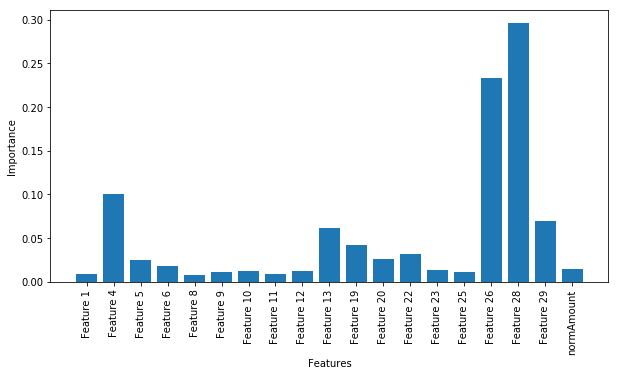

In [168]:
f, ax = plt.subplots(figsize=(10,5))
plt.bar(X_train.columns, model_ada_rf.feature_importances_)
plt.xticks(X_train.columns, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')


### Create a pruned Random tree to print the rules

<div class="alert alert-danger">
    The pruned tree image was created on local and images have been uploaded
</div>

In [109]:
# Do not need to prune again
# The images are available in the slides and on local

# Define the model as the random forest
model_rf_pruned = RandomForestClassifier(n_estimators=80,random_state=5, min_samples_split=5, min_samples_leaf=1, 
                                     max_features='sqrt', max_depth=3, bootstrap=False)

# Fit the model to our resampled dataset
model_rf_pruned.fit(X_resampled, y_resampled)

AUC Score:  0.9345119421438437


In [111]:
# # printing one decision tree in the Random Forest
# # The images are available in the slides and on local

# estimator = model_rf_pruned.estimators_[5]

# tree.export_graphviz(estimator, out_file='tree.dot', feature_names=X_train.columns,
#                     class_names = ['Non-Fraud', 'Fraud']) #produces dot file
# (graph,) = pydot.graph_from_dot_file('tree.dot')
# graph.write_png('images/random_forest_pruned_5.png')

In [58]:
#printing one decision tree in the Random Forest
# The images are available in the slides and on local

# estimator = model_rf_pruned.estimators_[2]

# tree.export_graphviz(estimator, out_file='tree.dot', feature_names=X_train.columns,
#                     class_names = ['Non-Fraud', 'Fraud']) #produces dot file
# (graph,) = pydot.graph_from_dot_file('tree.dot')
# graph.write_png('images/random_forest_pruned_2.png')

In [59]:
#printing one decision tree in the Random Forest
# The images are available in the slides and on local

# estimator = model_rf_pruned.estimators_[20]

# tree.export_graphviz(estimator, out_file='tree.dot', feature_names=X_train.columns,
#                     class_names = ['Non-Fraud', 'Fraud']) #produces dot file
# (graph,) = pydot.graph_from_dot_file('tree.dot')
# graph.write_png('images/random_forest_pruned_20.png')

In [60]:
#printing one decision tree in the Random Forest
# The images are available in the slides and on local

# estimator = model_rf_pruned.estimators_[15]

# tree.export_graphviz(estimator, out_file='tree.dot', feature_names=X_train.columns,
#                     class_names = ['Non-Fraud', 'Fraud']) #produces dot file
# (graph,) = pydot.graph_from_dot_file('tree.dot')
# graph.write_png('images/random_forest_pruned_15.png')

# Further Evaluation Metrics

## Plot learning curve

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


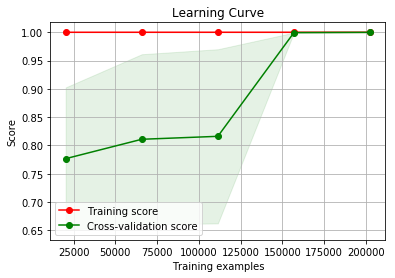

In [178]:
#Generate a simple plot of the test and training learning curve.
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title= "Learning Curve"
plot_learning_curve(model_rf_re, title, X_resampled, y_resampled)

plt.show()

<div class="alert alert-success">
From the learning curve, we can see that the bias-variance trade-off is good and we'll continue with this model
</div>

## Cross Validation

In [94]:
n_repeats = 5
n_splits=5
kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=None) 


model_rf_re = RandomForestClassifier(random_state=5)
auc_scores = []
f1_scores = []

i=1
for train_index, test_index in kf.split(X):
    
    print("Iteration: ", i)
    i+=1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Fit the model to our resampled dataset
    model_rf_re.fit(X_train, y_train)

    # Obtain predictions from the test data 
    predicted = model_rf_re.predict(X_test)

    # Predict probabilities
    probs = model_rf_re.predict_proba(X_test)
    auc_scores.append(roc_auc_score(y_test, probs[:,1]))
    f1_scores.append(f1_score(y_test, predicted))

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25


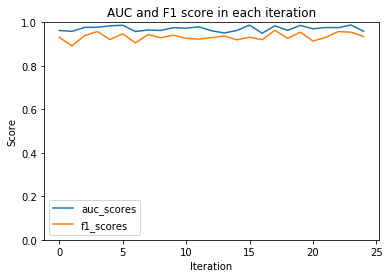

In [95]:
plt.plot(range(0,n_repeats*n_splits,1), auc_scores, label='auc_scores')
plt.plot(range(0,n_repeats*n_splits,1), f1_scores, label='f1_scores')
plt.ylim(0, 1)
plt.title('AUC and F1 score in each iteration')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.legend()
plt.show()

<div class="alert alert-success">
Thus, by the minimal fluctuation in F1-scores and AUC scores, we can confirm a lack of overfitting/underfitting
</div>

# Final Predicted Output

In [ ]:
predicted_df = X_test.copy()
predicted_df['predicted_fraud'] = predicted
predicted_df['actual_fraud'] = y_test

In [ ]:
# predicted_df.to_csv('data/predicted.csv')

In [ ]:
predicted_df.head()